# Chargement des modules 

In [2]:
# Les classiques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

# visualisation dynamique
import plotly.express as px

# Modules pour les séries chronologiques
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pmdarima.arima import auto_arima

# Chargement des données et visualisation

In [3]:

path = "/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Série chronologiques_Proïa/projet_electricité/Dataset_CB.csv"

EDF = pd.read_csv(path)

EDF.columns = ["DATE","CONSO"]

EDF.DATE = pd.to_datetime(EDF.DATE,format='%d/%m/%y %H:%M')

print("shape = ",EDF.shape)

EDF


shape =  (744, 2)


,DATE,CONSO
0,2023-08-01 00:00:00,522.646044
1,2023-08-01 01:00:00,142.889213
2,2023-08-01 02:00:00,497.052422
3,2023-08-01 03:00:00,110.082063
4,2023-08-01 04:00:00,333.036926
...,...,...
739,2023-08-31 19:00:00,1216.824530
740,2023-08-31 20:00:00,1867.397655
741,2023-08-31 21:00:00,6456.590007
742,2023-08-31 22:00:00,915.149345


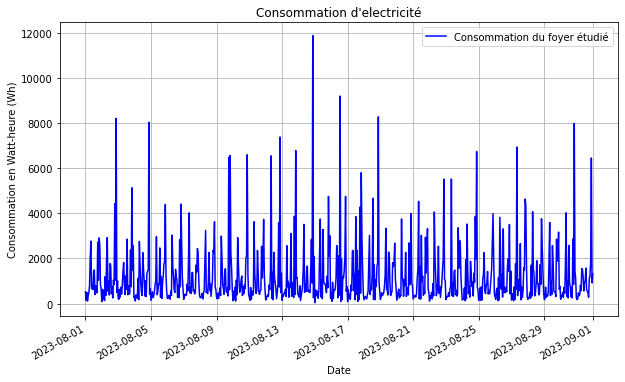

In [3]:
# Tracez les données avec une ligne solide bleue et ajoutez des marqueurs

plt.figure(figsize=(10,6))
plt.plot(EDF.DATE.values, EDF.CONSO.values, linestyle='-', color='b', label='Consommation du foyer étudié')
plt.legend()
plt.title("Consommation d'electricité")
plt.xlabel("Date")
plt.ylabel("Consommation en Watt-heure (Wh)")
plt.gcf().autofmt_xdate() # Personnalisez les axes pour afficher les dates de manière plus lisible
plt.grid(True)
plt.show()

# Passage au log pour atténuer les pics  

In [4]:
EDF['LOGCONSO'] = np.log(EDF.CONSO)
EDF.head()

,DATE,CONSO,LOGCONSO
0,2023-08-01 00:00:00,522.646044,6.258904
1,2023-08-01 01:00:00,142.889213,4.962070
2,2023-08-01 02:00:00,497.052422,6.208695
3,2023-08-01 03:00:00,110.082063,4.701226
4,2023-08-01 04:00:00,333.036926,5.808253


In [5]:
# Créez un graphique interactif avec Plotly Express
fig = px.line(EDF, x='DATE', y='LOGCONSO', labels={'DATE': 'Date', 'LOGCONSO': 'Log consommation'})
fig.update_layout(title="Log-consommation d'énergie du foyer")

# Affichez le graphique interactif
fig.show()

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


Au vu de ce graphique, la stationnarité ne semble pas remis en cause, nous allons appuyer cette hypothèse grâce aux tests ADF et KPSS

In [6]:
# On va différentier une fois pour regarder les incréments à une heure près
EDF["diff1"] = EDF.LOGCONSO.diff(1) 

# Créez un graphique interactif avec Plotly Express
fig = px.line(EDF, x='DATE', y="diff1", labels={'DATE': 'Date', 'diff1': ''})
fig.update_layout(title="Différentiation de la Log-consommation d'énergie du foyer")
fig.show()

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Au vu de ce graphique, la stationnarité ne semble pas trop remis en cause, nous allons appuyer cette hypothèse grâce aux tests ADF et KPSS

In [84]:
# On va différentier une fois pour regarder les incréments à 24 heures près
EDF["diff24"] = EDF.LOGCONSO.diff(24) 
fig = px.line(EDF, x='DATE', y="diff24", labels={'DATE': 'Date', 'diff24': ''})
fig.update_layout(title="Différentiation saisonnière de la Log-consommation d'énergie du foyer")
fig.show()

Au vu de ce graphique, la stationnarité au niveau de la variance du processus semble remis en cause, nous allons voir si les tests ADF et KPSS sont réceptifs à ce genre de non stationnarité. 

# Test de Stationnarité 

## Sans différentier

In [85]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.LOGCONSO) # Test ADF rejeté
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.LOGCONSO) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  0.0
KPSS p-val :  0.1


/tmp/ipykernel_19851/2687361320.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires, nous pouvons ainsi essayer de mettre un modèle mathématiques de type (AR, MA, ARIMA, SARIMA) que nous avons étudiés durant ce semestre. 

## Avec différentiation 

In [86]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.diff1.dropna()) # Test ADF rejeté
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.diff1.dropna()) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  6.256435132748781e-22
KPSS p-val :  0.1


/tmp/ipykernel_19851/1720817923.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires, nous pouvons ainsi essayer de mettre un modèle mathématiques de type (AR, MA, ARIMA, SARIMA) que nous avons étudiés durant ce semestre. 

## Avec différentiation saisonnière s=24

In [35]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.diff24.dropna()) # Test ADF rejeté au seuil de 5%
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.diff24.dropna()) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  0.00022114078230846984
KPSS p-val :  0.1


/tmp/ipykernel_19851/2374260748.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires au vu des tests, cependant nous avons observé une non stationnarité flagrante en variance du processus. Ceci illustre bien la méfiance que nous devons avoir face aux résultats des test ADF et KPSS.

# Étude des corrélations

## sans différentiation

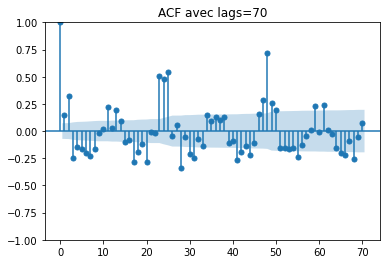

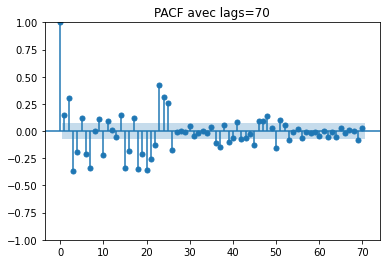

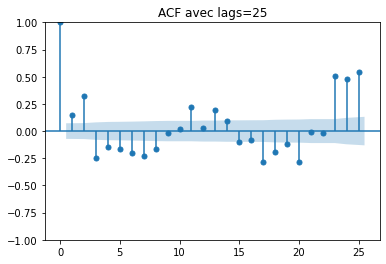

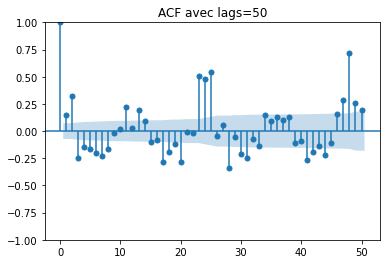

In [36]:
ACF = plot_acf(EDF.LOGCONSO, lags=70, alpha=0.05,title="ACF avec lags=70") 
PACF = plot_pacf(EDF.LOGCONSO, lags=70, alpha=0.05,title="PACF avec lags=70")

ACF = plot_acf(EDF.LOGCONSO, lags=25, alpha=0.05,title="ACF avec lags=25") 

ACF = plot_acf(EDF.LOGCONSO, lags=50, alpha=0.05,title="ACF avec lags=50")


On remarque qu'il y a un regain d'amplitude dans l'ACF au niveau de la valeur h=24 et h= 48, une saisonalité de 24 semble être visible. De plus cette information semble cohérente avec les données car chaque journée contient 24 heures donc 24 observations par jours. L'ACF et la PACF ne nous donne pas plus d'informations quand aux ordres (p,d,q) et (P,D,Q) pour un modèle de type SARIMA


## Avec différentiation

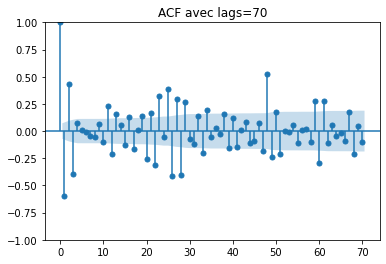

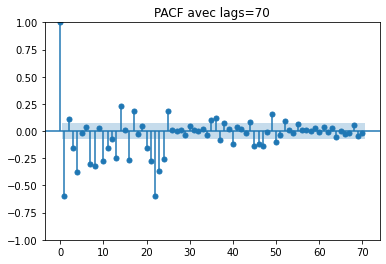

In [38]:
ACF = plot_acf(EDF.diff1.dropna(), lags=70, alpha=0.05,title="ACF avec lags=70") 
PACF = plot_pacf(EDF.diff1.dropna(), lags=70, alpha=0.05,title="PACF avec lags=70")


# Recherche avec la fonction Auto_arima

## Un modèle sans différentiation

In [7]:
auto_arima(EDF.LOGCONSO, start_p=0, start_q=0, seasonal=True, start_P=0, start_Q=0, m=24, d=0, D=0, with_intercept=True, stepwise=True, trace=True)
#force D=d=0 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2030.245, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1939.821, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4943.179, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=2022.800, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1106.752, Time=9.09 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1595.281, Time=5.93 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=32.69 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=974.376, Time=30.12 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=1682.031, Time=5.65 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=43.18 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=1154.748, Time=26.26 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=837.111, Time=42.04 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=1577.708, Time=21.25 sec
 ARIMA(1,0,1)(1,0,1)[24] inter

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

## Recherche d'un modèle qui minimise les scores AIC et BIC 

### Modèle 1

In [16]:
Mod1 = SARIMAX(EDF.LOGCONSO, order=(5, 0, 0), seasonal_order=(1, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod1 = Mod1.fit()
print(Mod1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09498D-01    |proj g|=  7.66078D-01

At iterate    5    f=  5.50346D-01    |proj g|=  4.93444D-01

At iterate   10    f=  4.40659D-01    |proj g|=  4.85079D-01

At iterate   15    f=  3.74918D-01    |proj g|=  3.58471D+00

At iterate   20    f=  3.68720D-01    |proj g|=  4.77678D+00

At iterate   25    f=  3.07768D-01    |proj g|=  4.54615D+00

At iterate   30    f=  3.02238D-01    |proj g|=  4.75369D-01

At iterate   35    f=  3.01694D-01    |proj g|=  2.57073D+00

At iterate   40    f=  3.01431D-01    |proj g|=  4.18126D-02

At iterate   45    f=  3.01172D-01    |proj g|=  1.78037D+00

At iterate   50    f=  2.99857D-01    |proj g|=  2.01052D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(5, 0, 0)x(1, 0, [1, 2], 24)   Log Likelihood                -223.094
Date:                                 Sat, 16 Dec 2023   AIC                            464.188
Time:                                         12:54:01   BIC                            505.083
Sample:                                              0   HQIC                           480.001
                                                 - 744                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4553      0.035    -12.916      0.000      -0.524      -0

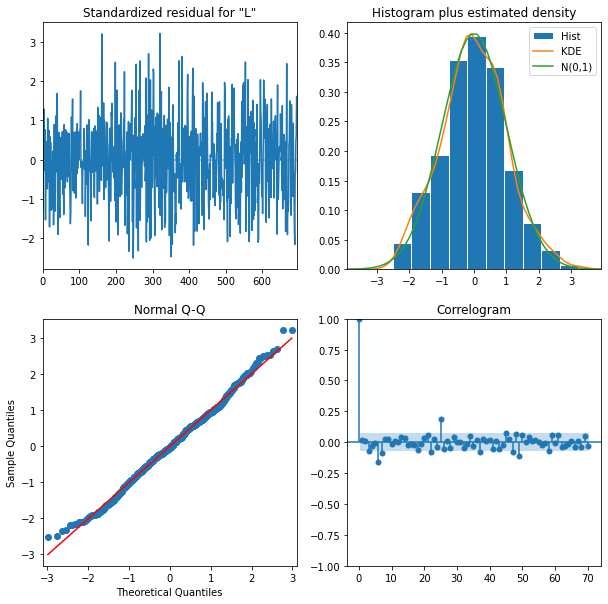

In [17]:
plot1 = Mod1.plot_diagnostics(figsize=(10,10),lags=70)

### Modèle 2

In [20]:
Mod2 = SARIMAX(EDF.LOGCONSO, order=(5, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod2 = Mod2.fit()
print(Mod2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11376D-01    |proj g|=  7.80335D-01

At iterate    5    f=  4.71615D-01    |proj g|=  2.64844D+00

At iterate   10    f=  4.16560D-01    |proj g|=  1.24870D+00

At iterate   15    f=  3.53180D-01    |proj g|=  2.22325D-01

At iterate   20    f=  3.27983D-01    |proj g|=  7.31144D+00

At iterate   25    f=  2.95668D-01    |proj g|=  1.24907D-01

At iterate   30    f=  2.95135D-01    |proj g|=  1.01250D+00

At iterate   35    f=  2.92002D-01    |proj g|=  1.14762D+00

At iterate   40    f=  2.91787D-01    |proj g|=  3.88562D-01

At iterate   45    f=  2.91002D-01    |proj g|=  7.78476D-02

At iterate   50    f=  2.90992D-01    |proj g|=  6.18667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(5, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -216.498
Date:                                 Sat, 16 Dec 2023   AIC                            452.996
Time:                                         13:03:12   BIC                            498.378
Sample:                                              0   HQIC                           470.549
                                                 - 744                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4634      0.036    -12.723      0.000      -0.535      -0

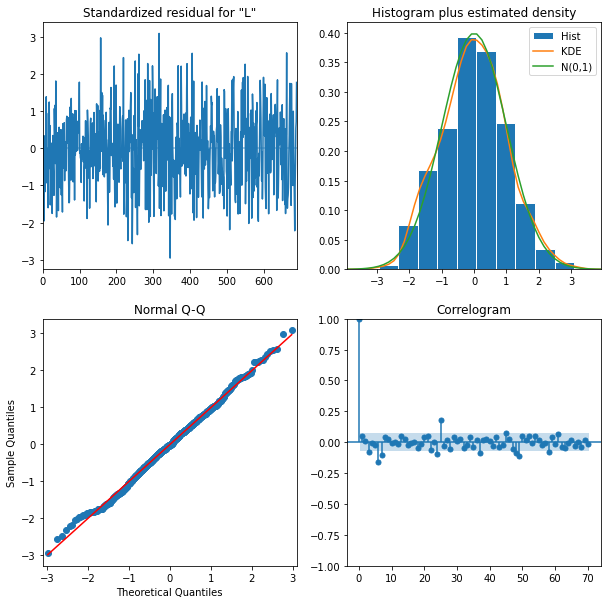

In [21]:
plot2 = Mod2.plot_diagnostics(figsize=(10,10),lags=70)

### Modèle 3

In [29]:
Mod3 = SARIMAX(EDF.LOGCONSO, order=(7, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod3 = Mod3.fit()
print(Mod3.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09401D-01    |proj g|=  7.75940D-01

At iterate    5    f=  4.66467D-01    |proj g|=  1.06950D+00

At iterate   10    f=  4.04892D-01    |proj g|=  6.35489D-01

At iterate   15    f=  3.61987D-01    |proj g|=  4.08058D-01

At iterate   20    f=  3.02452D-01    |proj g|=  1.32843D+01

At iterate   25    f=  2.88521D-01    |proj g|=  1.11783D-01

At iterate   30    f=  2.87543D-01    |proj g|=  1.43450D+00

At iterate   35    f=  2.80316D-01    |proj g|=  7.23584D+00

At iterate   40    f=  2.73918D-01    |proj g|=  4.87877D-02

At iterate   45    f=  2.73900D-01    |proj g|=  9.28065D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.73734D-01    |proj g|=  8.40201D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     65      1     0     0   8.402D-01   2.737D-01
  F =  0.27373405821391023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(7, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -203.658
Date:                                 Sat, 16 Dec 2023   AIC             

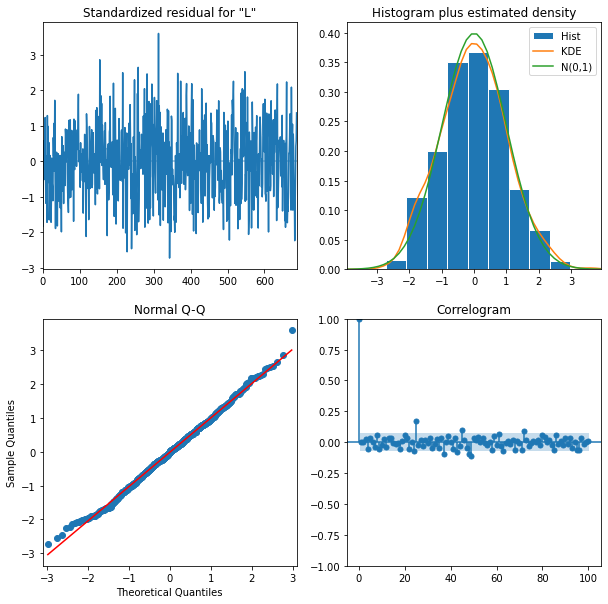

In [28]:
plot3 = Mod3.plot_diagnostics(figsize=(10,10),lags=100)

## Un modèle avec différentiation

In [32]:
auto_arima(EDF.LOGCONSO, start_p=0, start_q=0,max_p = 5, max_q=3,seasonal=True, start_P=0, start_Q=0, m=24, d=1, D=0, with_intercept=True, stepwise=True, trace=True)
#force d=0 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=2426.884, Time=0.11 sec


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1565.233, Time=7.84 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=32.88 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=2424.884, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=2094.653, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=24.06 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=49.23 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=1908.157, Time=7.17 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=85.50 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=2426.909, Time=2.44 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=8.71 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=21.36 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=18.74 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=35.86 sec
 ARIMA(1,1,0)(1,0,0)[24]             : AIC=1563.237, Time=2.32 sec
 ARIMA(1,1,0)(0,0,0)[24]             : AIC=2092.659, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[24]    

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 0, 24),
      suppress_warnings=True, with_intercept=False)

### Modèle d1

In [33]:
Mod_d1 = SARIMAX(EDF.LOGCONSO, order=(1, 1, 0), seasonal_order=(1, 0, 0, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod_d1 = Mod_d1.fit()
print(Mod_d1.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38869D+00    |proj g|=  6.06577D-01



At iterate    5    f=  9.97064D-01    |proj g|=  2.22996D-02

At iterate   10    f=  9.96991D-01    |proj g|=  3.70846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   5.008D-06   9.970D-01
  F =  0.99699106541383664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           LOGCONSO   No. Observations:                  744
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 24)   Log Likelihood                -741.761
Date:                     

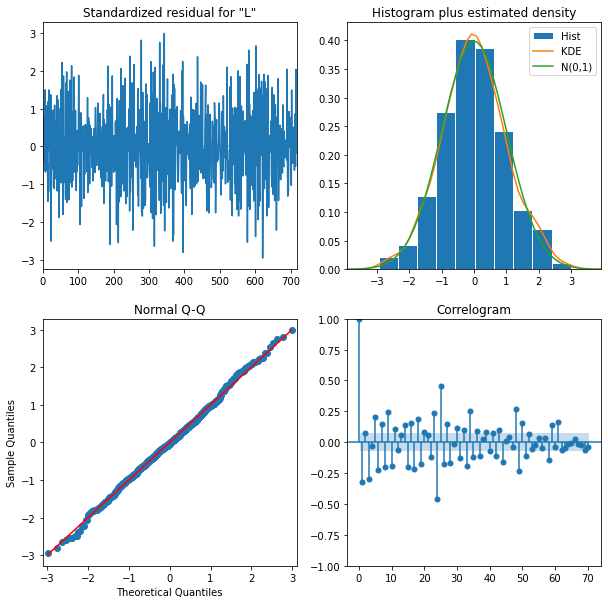

In [34]:
plot_d1 = Mod_d1.plot_diagnostics(figsize=(10,10),lags=70)

### Modèle d2

In [39]:
Mod_d2 = SARIMAX(EDF.LOGCONSO, order=(8, 1, 0), seasonal_order=(2, 0, 1, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod_d2 = Mod_d2.fit()
print(Mod_d2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88876D-01    |proj g|=  5.48028D-01

At iterate    5    f=  5.07786D-01    |proj g|=  1.71050D-01

At iterate   10    f=  3.98628D-01    |proj g|=  2.27772D+00

At iterate   15    f=  3.69821D-01    |proj g|=  5.36544D-01

At iterate   20    f=  3.44816D-01    |proj g|=  4.05160D-01

At iterate   25    f=  3.39891D-01    |proj g|=  1.05092D-01

At iterate   30    f=  3.38141D-01    |proj g|=  4.69337D-02

At iterate   35    f=  3.36147D-01    |proj g|=  1.13637D-01

At iterate   40    f=  3.33031D-01    |proj g|=  2.45615D-01

At iterate   45    f=  3.32144D-01    |proj g|=  4.27766D-02

At iterate   50    f=  3.28273D-01    |proj g|=  3.73982D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                             LOGCONSO   No. Observations:                  744
Model:             SARIMAX(8, 1, 0)x(2, 0, [1], 24)   Log Likelihood                -244.235
Date:                              Sat, 16 Dec 2023   AIC                            512.470
Time:                                      14:16:22   BIC                            566.858
Sample:                                           0   HQIC                           533.512
                                              - 744                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2711      0.037    -34.257      0.000      -1.344      -1.198
ar.L2         -0.71

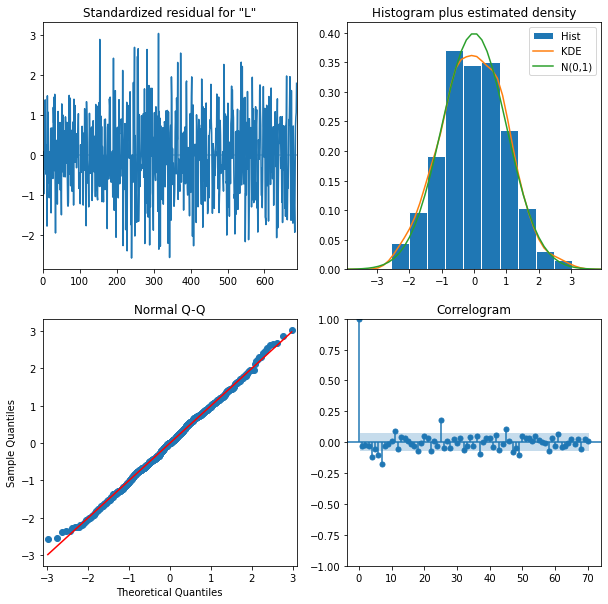

In [38]:
plot_d2 = Mod_d2.plot_diagnostics(figsize=(10,10),lags=70)


## Superposition des courbes pour les différents modèles précédents

In [ ]:
EDF['pred_Mod1'] = Mod1.fittedvalues
EDF['pred_Mod2'] = Mod2.fittedvalues
EDF['pred_Mod3'] = Mod3.fittedvalues
EDF['pred_Mod_d1'] = Mod_d1.fittedvalues
EDF['pred_Mod_d2'] = Mod_d2.fittedvalues

In [59]:

# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO', labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod1', color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle 1")

# Affichez le graphique interactif
fig.show()

# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO', labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod2', color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle 2")

# Affichez le graphique interactif
fig.show()


# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO', labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod3', color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle 3")

# Affichez le graphique interactif
fig.show()

# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO', labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod_d2', color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle d2")

# Affichez le graphique interactif
fig.show()


/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Les quatre modèles suivants semblent bien coller aux données fournies, nous pouvons maintenant choisir le plus performant à l'aide de la Cross Validation pour proposer une prédiction sur les 7 prochains jours. 

## Cross Validation 

In [8]:
M = len(EDF) - int(np.floor(0.2*len(EDF)))
EDF_Train = EDF.iloc[:M]
EDF_Test = EDF.iloc[M:]
EDF_Train.head()

,DATE,CONSO,LOGCONSO
0,2023-08-01 00:00:00,522.646044,6.258904
1,2023-08-01 01:00:00,142.889213,4.962070
2,2023-08-01 02:00:00,497.052422,6.208695
3,2023-08-01 03:00:00,110.082063,4.701226
4,2023-08-01 04:00:00,333.036926,5.808253


In [9]:
Mod1 = SARIMAX(EDF_Train.LOGCONSO, order=(5, 0, 0), seasonal_order=(1, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod1 = Mod1.fit()

Mod2 = SARIMAX(EDF_Train.LOGCONSO, order=(5, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod2 = Mod2.fit()

Mod3 = SARIMAX(EDF_Train.LOGCONSO, order=(7, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod3 = Mod3.fit()

Mod4 = SARIMAX(EDF_Train.LOGCONSO, order=(8, 1, 0), seasonal_order=(2, 0, 1, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod4 = Mod4.fit()

Mod = {"Mod1":Mod1,"Mod2":Mod2,"Mod3":Mod3,"Mod4":Mod4 }

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99010D-01    |proj g|=  7.57435D-01

At iterate    5    f=  4.64868D-01    |proj g|=  2.47866D+00

At iterate   10    f=  3.84304D-01    |proj g|=  2.86384D+00

At iterate   15    f=  3.20426D-01    |proj g|=  2.36450D+01

At iterate   20    f=  3.07808D-01    |proj g|=  3.85121D+00

At iterate   25    f=  2.90953D-01    |proj g|=  3.80244D+00

At iterate   30    f=  2.90059D-01    |proj g|=  1.36154D+00

At iterate   35    f=  2.89708D-01    |proj g|=  4.09389D-01

At iterate   40    f=  2.89642D-01    |proj g|=  5.27882D-02

At iterate   45    f=  2.89629D-01    |proj g|=  2.33643D-02

At iterate   50    f=  2.89614D-01    |proj g|=  2.69535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94713D-01    |proj g|=  7.68194D-01

At iterate    5    f=  4.46712D-01    |proj g|=  3.24133D-01

At iterate   10    f=  3.73669D-01    |proj g|=  8.94820D+00

At iterate   15    f=  3.38058D-01    |proj g|=  6.15563D-01

At iterate   20    f=  2.85814D-01    |proj g|=  1.00078D+01

At iterate   25    f=  2.77760D-01    |proj g|=  6.37568D-02

At iterate   30    f=  2.77087D-01    |proj g|=  8.96571D-01

At iterate   35    f=  2.73801D-01    |proj g|=  1.33636D-01

At iterate   40    f=  2.73706D-01    |proj g|=  4.13059D-02

At iterate   45    f=  2.73601D-01    |proj g|=  8.83967D-01

At iterate   50    f=  2.72265D-01    |proj g|=  3.60265D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92094D-01    |proj g|=  7.63345D-01

At iterate    5    f=  4.16635D-01    |proj g|=  1.66645D+00

At iterate   10    f=  3.79168D-01    |proj g|=  8.72667D-01

At iterate   15    f=  2.85756D-01    |proj g|=  1.28333D+01

At iterate   20    f=  2.69653D-01    |proj g|=  3.63264D-01

At iterate   25    f=  2.67645D-01    |proj g|=  2.77640D+00

At iterate   30    f=  2.65990D-01    |proj g|=  9.19530D-02

At iterate   35    f=  2.60883D-01    |proj g|=  6.64557D-01

At iterate   40    f=  2.58190D-01    |proj g|=  3.33027D-02

At iterate   45    f=  2.57900D-01    |proj g|=  7.04211D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.56182D-01    |proj g|=  2.96502D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   2.965D-01   2.562D-01
  F =  0.25618238186708203     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93710D-01    |proj g|=  4.82975D-01

At iterate    5    f=  5.11759D-01    |proj g|=  2.32870D-01

At iterate   10    f=  4.03545D-01   

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAE = []
MSE = []
RMSE = []
MAPE = []

for i in range(1,5):
    EDF_Test[f"val_{i}"] = Mod[f"Mod{i}"].get_forecast(steps=len(EDF_Test)).summary_frame(alpha=0.05)['mean']
    MAE.append(mean_absolute_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"]) )
    MSE.append(mean_squared_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"]) )
    RMSE.append(mean_squared_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"],squared=False) )
    MAPE.append(mean_absolute_percentage_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"]) )

/tmp/ipykernel_50126/2112451402.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EDF_Test[f"val_{i}"] = Mod[f"Mod{i}"].get_forecast(steps=len(EDF_Test)).summary_frame(alpha=0.05)['mean']
/tmp/ipykernel_50126/2112451402.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EDF_Test[f"val_{i}"] = Mod[f"Mod{i}"].get_forecast(steps=len(EDF_Test)).summary_frame(alpha=0.05)['mean']
/tmp/ipykernel_50126/2112451402.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

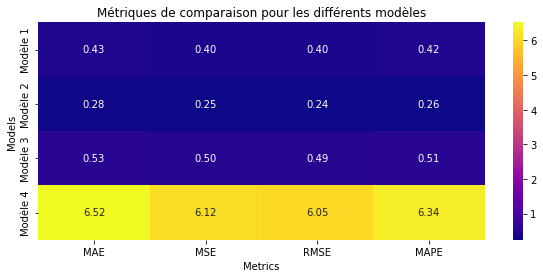

In [12]:
Matrix = np.array([MAE,MSE,RMSE,MAPE])

plt.figure(figsize=(10, 4))
ax = sns.heatmap(Matrix, annot=True, fmt=".2f", cmap="plasma", xticklabels=['MAE', 'MSE', 'RMSE', 'MAPE'], yticklabels=['Modèle 1', 'Modèle 2','Modèle 3','Modèle 4'])

plt.title("Métriques de comparaison pour les différents modèles")
plt.xlabel("Metrics")
plt.ylabel("Models")

plt.show()

Le choix du modèle 2 semble mieux coller aux données après prédiction. Nous allons donc choisir ce modèle finalement pour faire nos prédictions des 7 prochains jours. 

In [13]:
Best_Mod = SARIMAX(EDF.LOGCONSO, order=(5, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Best_Mod = Best_Mod.fit()
print(Best_Mod.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11376D-01    |proj g|=  7.80335D-01

At iterate    5    f=  4.71615D-01    |proj g|=  2.64844D+00

At iterate   10    f=  4.16560D-01    |proj g|=  1.24870D+00

At iterate   15    f=  3.53180D-01    |proj g|=  2.22325D-01

At iterate   20    f=  3.27983D-01    |proj g|=  7.31144D+00

At iterate   25    f=  2.95668D-01    |proj g|=  1.24907D-01

At iterate   30    f=  2.95135D-01    |proj g|=  1.01250D+00

At iterate   35    f=  2.92002D-01    |proj g|=  1.14762D+00

At iterate   40    f=  2.91787D-01    |proj g|=  3.88562D-01

At iterate   45    f=  2.91002D-01    |proj g|=  7.78476D-02

At iterate   50    f=  2.90992D-01    |proj g|=  6.18667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(5, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -216.498
Date:                                 Sat, 16 Dec 2023   AIC                            452.996
Time:                                         17:59:09   BIC                            498.378
Sample:                                              0   HQIC                           470.549
                                                 - 744                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4634      0.036    -12.723      0.000      -0.535      -0

<Figure size 720x720 with 0 Axes>

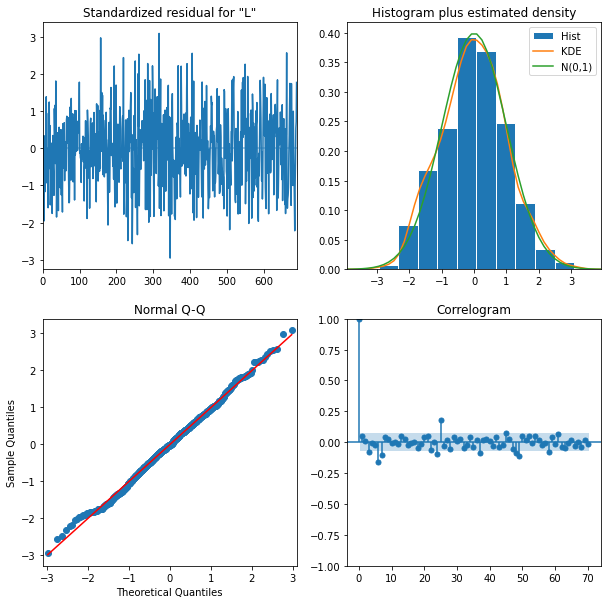

In [14]:
plt.figure(figsize=(10,10))
plot_best = Best_Mod.plot_diagnostics(figsize=(10,10),lags=70)

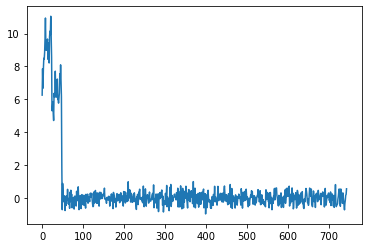

<AxesSubplot:>

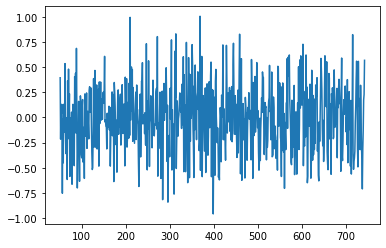

In [27]:
Best_Mod.resid.plot()
plt.show()
Res = Best_Mod.resid[Best_Mod.resid.index>50].values
Best_Mod.resid[Best_Mod.resid.index>50].plot()

In [36]:
# Coup d'oeil sur les résidus
TestLB = sm.stats.acorr_ljungbox(Res, lags=[5]) # Test de Ljung-Box au lag 5
print("LB p-val : ", TestLB["lb_pvalue"])
TestN = sm.stats.diagnostic.lilliefors(Res) # Test de Lilliefors de normalité un peu comme le test de Shapiro mais dans un autre module 
print("Norm p-val : ", TestN[1])

LB p-val :  5    0.356738
Name: lb_pvalue, dtype: float64
Norm p-val :  0.8004043315004497


* En prenant un lags assez petit (Lags < 6) on a un non rejet de H0:"Les résidus sont un bruit blanc"

* Nous avons aussi un non rejet de l'hypothèse de Normalité pour les résidus

Nous allons pouvoir faire de la prédiction et utiliser l'hyposthèse de normalité des résidu dans celle-ci. 

In [43]:
Pred = Best_Mod.get_forecast(steps=7*24).summary_frame(alpha=0.05)

### Représentation graphique avec la doc du cours 

/tmp/ipykernel_50126/2971745779.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(range(n, n+7*24), np.exp(Pred['mean'].values + Best_Mod.params[5]/2), linestyle='--', color="violet") #Mod01F.params[5] correspond à la variance


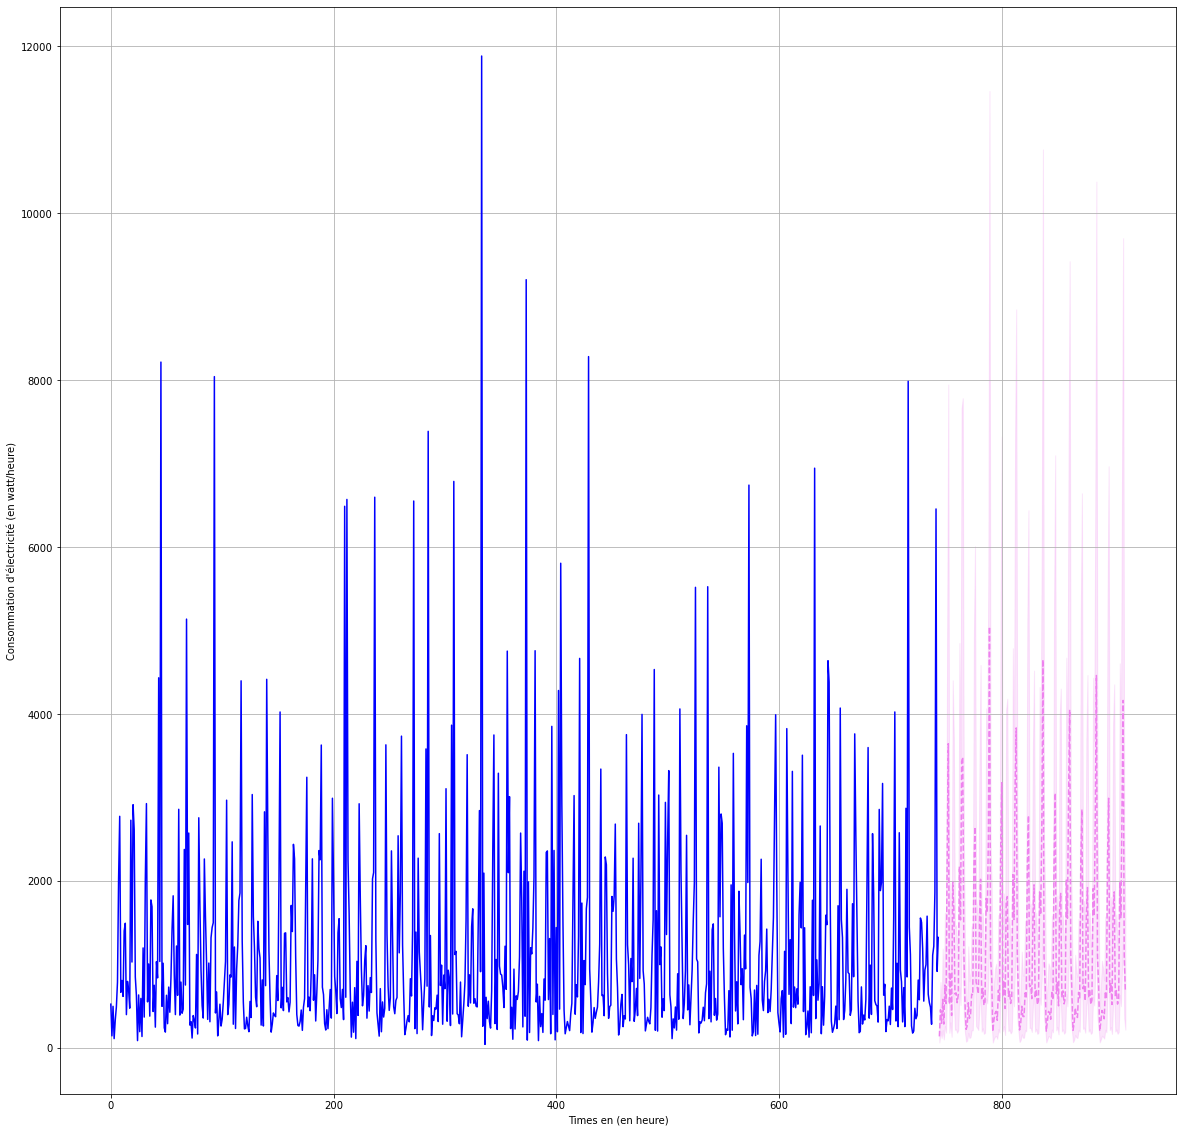

In [44]:
n = len(EDF.CONSO)

plt.figure(figsize=(20,20))
plt.plot(EDF.CONSO.values, color="blue")
plt.plot(range(n, n+7*24), np.exp(Pred['mean'].values + Best_Mod.params[5]/2), linestyle='--', color="violet") #Mod01F.params[5] correspond à la variance
plt.fill_between(range(n, n+7*24), np.exp(Pred['mean_ci_lower']), np.exp(Pred['mean_ci_upper']), color='violet', alpha=0.2)
plt.xlabel("Times en (en heure)")
plt.ylabel("Consommation d'électricité (en watt/heure)")
plt.grid()

### Représentation graphique intéractive 

In [55]:
pred_dates = pd.date_range(start=EDF.DATE.values[-1]+1, periods=7*24, freq='H')  #Le temps futur
predictions = np.exp(Pred['mean'].values + Best_Mod.params[5]/2)  # les prédictions à venir

# Créer le graphique Plotly
fig = px.line(EDF, x='DATE', y='CONSO', labels={'CONSO': "Consommation d'électricité"})

# Ajouter les prédictions
fig.add_scatter(x=pred_dates, y=predictions, mode='lines', name='Prédictions', line=dict(color='violet', dash='dash'))

# Ajouter la zone de confiance
fig.add_scatter(x=pred_dates, y=np.exp(Pred['mean_ci_lower']), fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False)
fig.add_scatter(x=pred_dates, y=np.exp(Pred['mean_ci_upper']), fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False)

# Mettre à jour le layout
fig.update_layout(title="Consommation d'électricité avec prédictions", xaxis_title='Temps (en heure)', yaxis_title='Consommation (en watt/heure)')

# Afficher le graphique
fig.show()

/tmp/ipykernel_50126/1253614972.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Seconde approche avec un desompose clasique de EDF.LONGCONSO

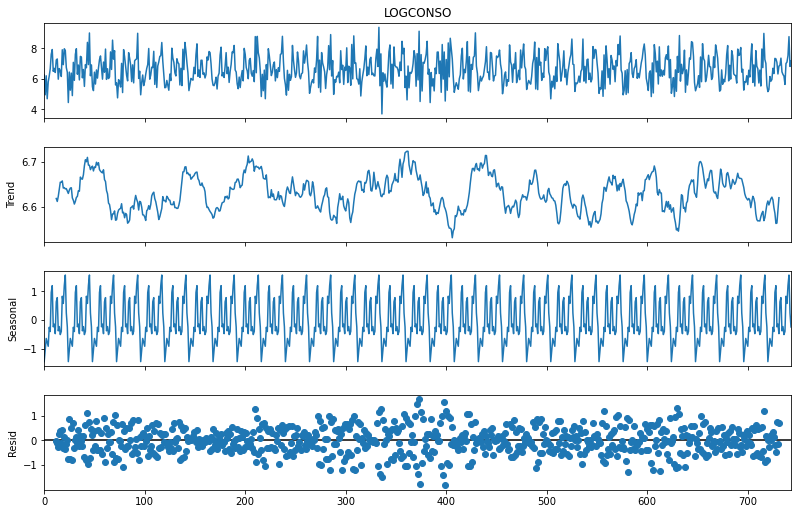

In [56]:


Decomp = sm.tsa.seasonal_decompose(EDF.LOGCONSO, model='additive', period=24)  # Modèle additif

plotd1 = Decomp.plot()
plt.gcf().set_size_inches(12, 8)  # Redimensionner la figure
plt.show() 

In [58]:
Mean = EDF.LOGCONSO.mean()
EDF["LC_res"] = EDF.LOGCONSO -Decomp.seasonal -Mean

fig = px.line(EDF, x='DATE', y="LC_res", labels={'DATE': 'Date', 'LC_res': 'Résidu '})
fig.update_layout(title="Log-consommation d'énergie du foyer centrée et sans composante périodique")
fig.show()


/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Au vu de ce graphique, la stationnarité au niveau de la variance du processus semble remise en cause. 